In [87]:
'''Numerical Study'''

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import numpy as np

import pandas as pd

import folium

import geopandas as gp

import copy

from shapely.geometry import Point, Polygon

import h3

In [61]:
def Get_Cumulative(n,bins):
    
    indexs=[]
    acc_freq=[]
    bins=bins.tolist()
    dis=bins[1]-bins[0]
    freq=[f*dis for f in n]
    for i,value in enumerate(bins):
        if i<=len(bins)-2:
            index=(bins[i]+bins[i+1])/2
            indexs.append(index)

    for i in range(0,len(freq)):
        if i==0:
            temp=freq[0]
        else:
            temp=sum(freq[:i+1])
        acc_freq.append(temp)

    return indexs,acc_freq

def Get_label(fee):
    
    fee=min(100,fee)
    
    fee=max(40,fee)
    
    fee=int(fee/10)
    
    return fee

In [34]:
Strategy='OPT'

Geometry=np.load('./Data/Initialization/Geo.npy',allow_pickle=True).item()

'''Load data'''

Order_df=pd.read_csv('./Data/Processed/Dispatched_Order_'+str(Strategy)+'.csv')

Order_df=Order_df.drop(columns=['Unnamed: 0'])

Driver_df=pd.read_csv('./Data/Processed/Dispatched_Driver_'+str(Strategy)+'.csv')

Driver_df=Driver_df.drop(columns=['Unnamed: 0'])

Broadcast_df=pd.read_csv('./Data/Processed/Broadcast_'+str(Strategy)+'.csv')

Broadcast_df=Broadcast_df.drop(columns=['Unnamed: 0'])



# Broadcasting

In [62]:
'''Responding orders'''

Order_list=list(Order_df.loc[(Order_df['driver_id']!='Canceled')&(Order_df['driver_id']!='Waiting'),'order_id'])

Order_fee={}

for idx,row in Order_df.iterrows():
    
    if row['order_id'] in Order_list:
        
        Order_fee[row['order_id']]=row['fee']
        
        
Broadcast_Stat=Broadcast_df.loc[Broadcast_df['order_id'].isin(Order_list)].groupby('order_id').count()

Broadcast_Stat['order_id']=Broadcast_Stat.index

Broadcast_Stat=Broadcast_Stat[['order_id','driver_id']]

Broadcast_Stat=Broadcast_Stat.reset_index(drop=True)

Broadcast_Stat=Broadcast_Stat.rename(columns={'driver_id':'broadcast'})

Broadcast_Stat['fee']=Broadcast_Stat.apply(lambda x:Order_fee[x['order_id']],axis=1)

Broadcast_Stat['label']=Broadcast_Stat.apply(lambda x:Get_label(x['fee']),axis=1)

Broadcast_Stat=Broadcast_Stat.sort_values(by='broadcast', ascending=False)

Broadcast_Stat



,order_id,broadcast,fee,label
1209,439972501,3828,10,4
2083,439984250,1763,15,4
2250,439986528,1364,15,4
10339,440090132,1144,17,4
5157,440023487,989,15,4
...,...,...,...,...
5401,440026439,1,57,5
8099,440060968,1,152,10
8104,440061032,1,81,8
9624,440080169,1,120,10


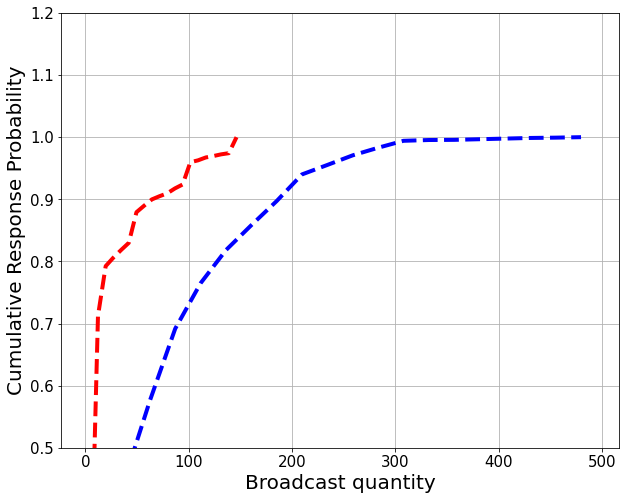

In [74]:
'''Cumulative_Distribution_Function'''

figsize = 10,8

figure,ax1 = plt.subplots(figsize=figsize)

plt.tick_params(labelsize=15)

labels = ax1.get_xticklabels() + ax1.get_yticklabels()

font = {'weight' : 'normal',\
        'size': 20}



n, bins, patches = ax1.hist(Broadcast_Stat.loc[(Broadcast_Stat['broadcast']<=500)&(Broadcast_Stat['label']>=6),'broadcast'],bins =20, alpha = 0.0,edgecolor='k',density = True,facecolor='blue')

X_arr,Y_arr=Get_Cumulative(n,bins)

ax1.plot(X_arr,Y_arr,'r--',linewidth=4)


n, bins, patches = ax1.hist(Broadcast_Stat.loc[(Broadcast_Stat['broadcast']<=500)&(Broadcast_Stat['label']<6),'broadcast'],bins =20, alpha = 0.0,edgecolor='k',density = True,facecolor='blue')

X_arr,Y_arr=Get_Cumulative(n,bins)

ax1.plot(X_arr,Y_arr,'b--',linewidth=4)

ax1.set_ylim([0.5,1.2])


ax1.set_xlabel('Broadcast quantity',font)

ax1.set_ylabel('Cumulative Response Probability',font)

plt.grid()



plt.show()

# Spatial Distribution

In [92]:
dir(gp)

['GeoDataFrame',
 'GeoSeries',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_compat',
 '_config',
 '_vectorized',
 '_version',
 'array',
 'base',
 'clip',
 'datasets',
 'geodataframe',
 'geopandas',
 'geoseries',
 'gpd',
 'io',
 'np',
 'options',
 'overlay',
 'pd',
 'plotting',
 'points_from_xy',
 'read_feather',
 'read_file',
 'read_parquet',
 'read_postgis',
 'show_versions',
 'sindex',
 'sjoin',
 'tools']

In [170]:
Response_Stat=Order_df[(Order_df['driver_id']!='Canceled')].groupby('start_grid').count()

Response_Stat['grid']=Response_Stat.index

Response_Stat=Response_Stat[['grid','order_id']]

Response_Stat=Response_Stat.reset_index(drop=True)

Response_Stat=Response_Stat.rename(columns={'order_id':'response_num'})

Order_Stat=Order_df.groupby('start_grid').count()

Order_Stat['grid']=Order_Stat.index

Order_Stat=Order_Stat[['grid','order_id']]

Order_Stat=Order_Stat.reset_index(drop=True)

Order_Stat=Order_Stat.rename(columns={'order_id':'order_num'})

Order_Stat=Order_Stat.merge(Response_Stat,on='grid',how='left')

Order_Stat=Order_Stat.fillna(0.0)

Order_Stat['ratio']=Order_Stat.apply(lambda x:100*round(x['response_num']/x['order_num'],2),axis=1)

Order_Stat['geometry']=Order_Stat.apply(lambda x:[[float(x[1]),float(x[0])] for x in h3.h3_to_geo_boundary(x['grid'])],axis=1)

# Order_Stat['geometry']=Order_Stat.apply(lambda x:Polygon([(float(x[1]),float(x[0])) for x in h3.h3_to_geo_boundary(x['grid'])]),axis=1)

# Order_Stat = gp.GeoDataFrame(Order_Stat, geometry=Order_Stat.geometry)

# Order_Stat=Order_Stat.set_crs(epsg=4326)

Order_Stat



,grid,order_num,response_num,ratio,geometry
0,88411c0001fffff,10,10.0,100.0,"[[114.2408868952159, 22.752591397361066], [114..."
1,88411c0005fffff,1,1.0,100.0,"[[114.2462151919149, 22.75882266216472], [114...."
2,88411c0007fffff,3,3.0,100.0,"[[114.23753813660815, 22.760454363361667], [11..."
3,88411c0009fffff,10,10.0,100.0,"[[114.24423535090146, 22.744728167743517], [11..."
4,88411c000bfffff,4,4.0,100.0,"[[114.23555853021634, 22.746359307443697], [11..."
...,...,...,...,...,...
1420,88411cb9bdfffff,10,10.0,100.0,"[[114.10844308750688, 22.53841064060362], [114..."
1421,88411cc457fffff,1,1.0,100.0,"[[114.49617636859516, 22.63930884954347], [114..."
1422,88411cc619fffff,1,1.0,100.0,"[[114.5108421781539, 22.585903650370355], [114..."
1423,88411cc6c3fffff,1,1.0,100.0,"[[114.47625340510982, 22.592452762269982], [11..."


In [177]:
help(folium.Choropleth)

Help on class Choropleth in module folium.features:

class Choropleth(folium.map.FeatureGroup)
 |  Choropleth(geo_data, data=None, columns=None, key_on=None, bins=6, fill_color=None, nan_fill_color='black', fill_opacity=0.6, nan_fill_opacity=None, line_color='black', line_weight=1, line_opacity=1, name=None, legend_name='', overlay=True, control=True, show=True, topojson=None, smooth_factor=None, highlight=None, **kwargs)
 |  
 |  Apply a GeoJSON overlay to the map.
 |  
 |  Plot a GeoJSON overlay on the base map. There is no requirement
 |  to bind data (passing just a GeoJSON plots a single-color overlay),
 |  but there is a data binding option to map your columnar data to
 |  different feature objects with a color scale.
 |  
 |  If data is passed as a Pandas DataFrame, the "columns" and "key-on"
 |  keywords must be included, the first to indicate which DataFrame
 |  columns to use, the second to indicate the layer in the GeoJSON
 |  on which to key the data. The 'columns' keyword 

In [189]:
GeoData=list()
         
for idx,row in Order_Stat.iterrows():
    
    GeoData.append({"type":"Feature",\
                    "id":row['grid'],\
                    "geometry":{"type":"Polygon",\
                                "coordinates":[row['geometry']]
                               }
                   })

    
GeoJson={"type":"FeatureCollection","features":GeoData}

GeoJson

'''Background'''

background = folium.Map([22.648883, 114.045011],tiles='CartoDB positron',zoom_start=10)

'''Zones'''

choropleth1 =folium.Choropleth(
    geo_data=Geometry['Shenzhen'],
    fill_color='blue',
    fill_opacity=0.0,
    name='Zone').add_to(background)

choropleth2 =folium.Choropleth(
    geo_data=GeoJson,
    data=Order_Stat,
    columns=['grid', 'ratio'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Response Rate (%)',
    highlight=True,
    name='Heatmap').add_to(background)

folium.LayerControl().add_to(background)


background.save('Heatmap.html')

# Cancel Analysing

In [75]:
STAT=Order_df[Order_df['driver_id']=='Canceled'].groupby('create_step').count().sort_values(by='order_id', ascending=False)

EXAM_ORDER=Order_df[(Order_df['driver_id']=='Canceled')&(Order_df['create_step']==STAT.index[0])]

EXAM_DRIVER=Driver_df[(Driver_df['order_id']=='Idle')&(Driver_df['step']==STAT.index[0])]


In [76]:
'''Background'''

background = folium.Map([22.648883, 114.045011],tiles='CartoDB positron',zoom_start=10)

'''Zones'''

folium.Choropleth(
    geo_data=Geometry['Shenzhen'],
    fill_color='blue',
    fill_opacity=0.0,
    name='Zone').add_to(background)

folium.LayerControl().add_to(background)

for idx,row in EXAM_ORDER.iterrows():
    
    folium.Circle(
    radius=10,
    location=[row['start_lat'],row['start_lng']],
    color='red',
    fill=True,
    ).add_to(background)
    
for idx,row in EXAM_DRIVER.iterrows():
    
    folium.Circle(
    radius=10,
    location=[row['latitude'],row['longitude']],
    color='green',
    fill=True,
    ).add_to(background)
    
background